# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

/Users/siweiwang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
!mkdir data

mkdir: data: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

SVHN Training Set: 182MB [01:26, 2.10MB/s]                              
SVHN Testing Set: 64.3MB [00:23, 2.72MB/s]                            


These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

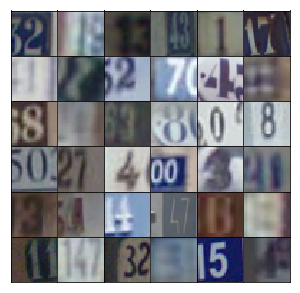

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [17]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training = training)
        x1 = tf.maximum(alpha * x1, x1)
        # 4X4X512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha* x3, x3)
        # 16X16X128
    
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
                                        
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [39]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8X8X128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [40]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [41]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [42]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [43]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [44]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [ ]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/25... Discriminator Loss: 1.5140... Generator Loss: 0.5205
Epoch 1/25... Discriminator Loss: 0.4125... Generator Loss: 2.1062
Epoch 1/25... Discriminator Loss: 0.1677... Generator Loss: 2.9872
Epoch 1/25... Discriminator Loss: 0.1669... Generator Loss: 2.7602
Epoch 1/25... Discriminator Loss: 0.1588... Generator Loss: 2.8333
Epoch 1/25... Discriminator Loss: 0.0876... Generator Loss: 2.8790
Epoch 1/25... Discriminator Loss: 0.2124... Generator Loss: 2.2583
Epoch 1/25... Discriminator Loss: 0.3107... Generator Loss: 2.4359
Epoch 1/25... Discriminator Loss: 1.5040... Generator Loss: 1.5290
Epoch 1/25... Discriminator Loss: 0.8660... Generator Loss: 1.3968


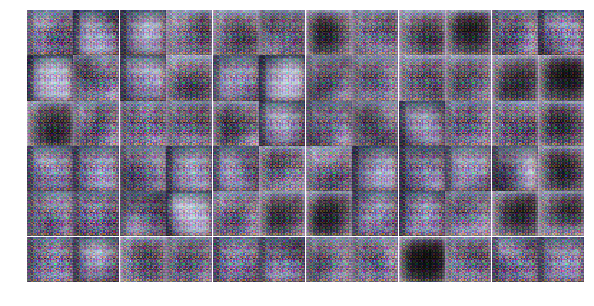

Epoch 1/25... Discriminator Loss: 0.5189... Generator Loss: 1.9896
Epoch 1/25... Discriminator Loss: 0.5130... Generator Loss: 1.9999
Epoch 1/25... Discriminator Loss: 0.6586... Generator Loss: 1.2394
Epoch 1/25... Discriminator Loss: 0.3131... Generator Loss: 2.5606
Epoch 1/25... Discriminator Loss: 0.5158... Generator Loss: 1.5762
Epoch 1/25... Discriminator Loss: 0.4986... Generator Loss: 2.5658
Epoch 1/25... Discriminator Loss: 0.2969... Generator Loss: 2.2156
Epoch 1/25... Discriminator Loss: 0.9735... Generator Loss: 5.1309
Epoch 1/25... Discriminator Loss: 0.4243... Generator Loss: 2.1941
Epoch 1/25... Discriminator Loss: 1.4158... Generator Loss: 7.0108


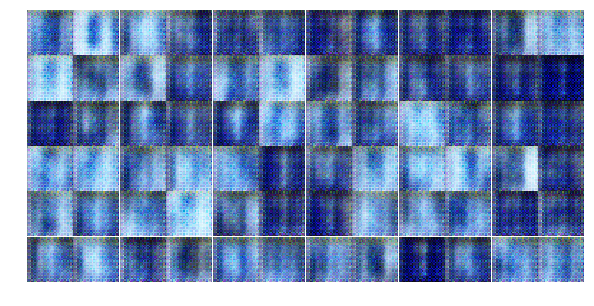

Epoch 1/25... Discriminator Loss: 3.0929... Generator Loss: 0.0652
Epoch 1/25... Discriminator Loss: 0.5190... Generator Loss: 1.4975
Epoch 1/25... Discriminator Loss: 0.3133... Generator Loss: 2.1795
Epoch 1/25... Discriminator Loss: 0.1648... Generator Loss: 5.9532
Epoch 1/25... Discriminator Loss: 0.2319... Generator Loss: 2.5145
Epoch 1/25... Discriminator Loss: 1.3501... Generator Loss: 1.0849
Epoch 1/25... Discriminator Loss: 0.7636... Generator Loss: 1.0055
Epoch 1/25... Discriminator Loss: 0.9940... Generator Loss: 0.8299
Epoch 1/25... Discriminator Loss: 0.9943... Generator Loss: 1.4712
Epoch 1/25... Discriminator Loss: 0.9644... Generator Loss: 1.8072


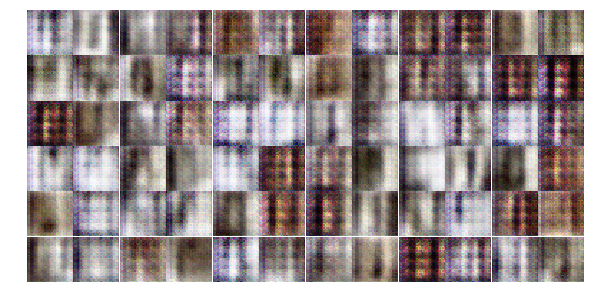

Epoch 1/25... Discriminator Loss: 0.9129... Generator Loss: 1.2936
Epoch 1/25... Discriminator Loss: 1.1911... Generator Loss: 0.8528
Epoch 1/25... Discriminator Loss: 0.7811... Generator Loss: 1.1516
Epoch 1/25... Discriminator Loss: 0.8960... Generator Loss: 1.0991
Epoch 1/25... Discriminator Loss: 0.5561... Generator Loss: 1.7915
Epoch 1/25... Discriminator Loss: 1.1180... Generator Loss: 0.6168
Epoch 1/25... Discriminator Loss: 0.6216... Generator Loss: 1.2829
Epoch 1/25... Discriminator Loss: 0.8124... Generator Loss: 1.8602
Epoch 1/25... Discriminator Loss: 0.8703... Generator Loss: 1.1300
Epoch 1/25... Discriminator Loss: 0.5349... Generator Loss: 1.5013


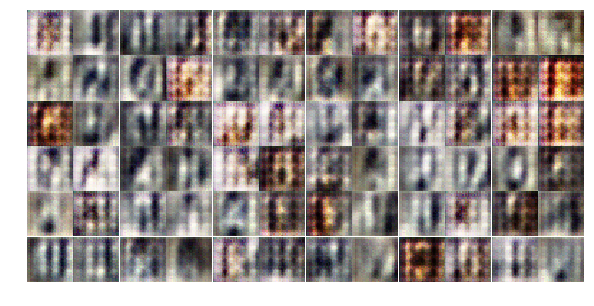

Epoch 1/25... Discriminator Loss: 0.7557... Generator Loss: 1.0930
Epoch 1/25... Discriminator Loss: 0.7299... Generator Loss: 1.3250
Epoch 1/25... Discriminator Loss: 0.9413... Generator Loss: 0.9574
Epoch 1/25... Discriminator Loss: 0.9628... Generator Loss: 1.2233
Epoch 1/25... Discriminator Loss: 0.6937... Generator Loss: 1.5997
Epoch 1/25... Discriminator Loss: 0.7313... Generator Loss: 1.3590
Epoch 1/25... Discriminator Loss: 0.6679... Generator Loss: 1.7859
Epoch 1/25... Discriminator Loss: 0.7639... Generator Loss: 2.3120
Epoch 1/25... Discriminator Loss: 0.5380... Generator Loss: 1.5085
Epoch 1/25... Discriminator Loss: 1.0008... Generator Loss: 0.8735


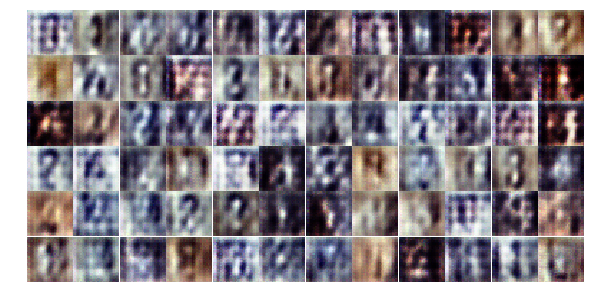

Epoch 1/25... Discriminator Loss: 0.7089... Generator Loss: 1.9058
Epoch 1/25... Discriminator Loss: 0.6018... Generator Loss: 1.9379
Epoch 1/25... Discriminator Loss: 0.6994... Generator Loss: 1.7384
Epoch 1/25... Discriminator Loss: 1.3687... Generator Loss: 0.5934
Epoch 1/25... Discriminator Loss: 0.9664... Generator Loss: 1.3172
Epoch 1/25... Discriminator Loss: 1.1952... Generator Loss: 0.7224
Epoch 1/25... Discriminator Loss: 1.3475... Generator Loss: 0.7602
Epoch 2/25... Discriminator Loss: 1.2454... Generator Loss: 1.0866
Epoch 2/25... Discriminator Loss: 0.8663... Generator Loss: 1.3313
Epoch 2/25... Discriminator Loss: 0.7242... Generator Loss: 1.3057


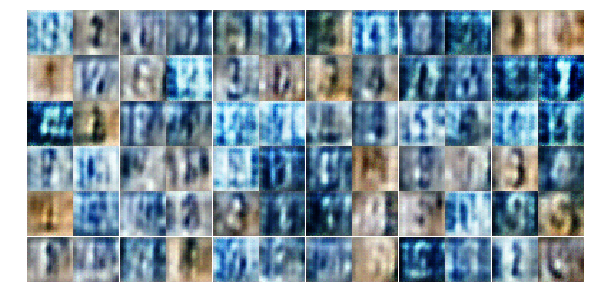

Epoch 2/25... Discriminator Loss: 0.8173... Generator Loss: 1.3163
Epoch 2/25... Discriminator Loss: 0.6924... Generator Loss: 1.4644
Epoch 2/25... Discriminator Loss: 0.9780... Generator Loss: 0.9815
Epoch 2/25... Discriminator Loss: 0.8512... Generator Loss: 1.2955
Epoch 2/25... Discriminator Loss: 1.1103... Generator Loss: 0.8766
Epoch 2/25... Discriminator Loss: 0.8795... Generator Loss: 0.9104
Epoch 2/25... Discriminator Loss: 0.9412... Generator Loss: 1.1977
Epoch 2/25... Discriminator Loss: 0.8301... Generator Loss: 1.4634
Epoch 2/25... Discriminator Loss: 1.0686... Generator Loss: 0.9489
Epoch 2/25... Discriminator Loss: 0.7254... Generator Loss: 1.1749


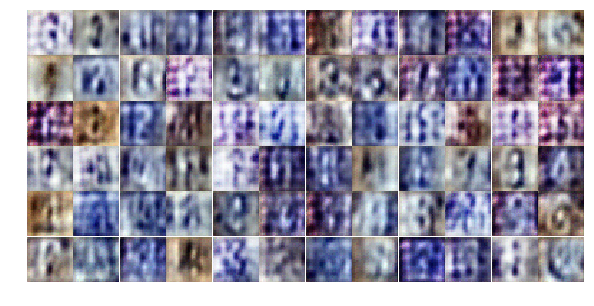

Epoch 2/25... Discriminator Loss: 1.2071... Generator Loss: 0.6851
Epoch 2/25... Discriminator Loss: 1.1075... Generator Loss: 0.9197
Epoch 2/25... Discriminator Loss: 0.9401... Generator Loss: 1.3614
Epoch 2/25... Discriminator Loss: 0.8313... Generator Loss: 1.2307
Epoch 2/25... Discriminator Loss: 1.0588... Generator Loss: 0.7855
Epoch 2/25... Discriminator Loss: 1.3636... Generator Loss: 0.5988
Epoch 2/25... Discriminator Loss: 1.2296... Generator Loss: 0.8055
Epoch 2/25... Discriminator Loss: 0.8441... Generator Loss: 1.0556
Epoch 2/25... Discriminator Loss: 0.7629... Generator Loss: 1.2851
Epoch 2/25... Discriminator Loss: 0.9287... Generator Loss: 0.7488


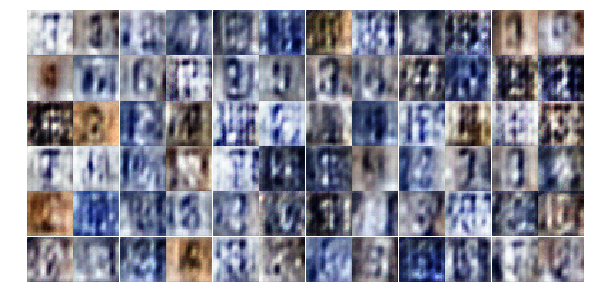

Epoch 2/25... Discriminator Loss: 0.8655... Generator Loss: 1.3144
Epoch 2/25... Discriminator Loss: 0.9981... Generator Loss: 1.0355
Epoch 2/25... Discriminator Loss: 0.8070... Generator Loss: 1.2713
Epoch 2/25... Discriminator Loss: 1.2070... Generator Loss: 0.7242
Epoch 2/25... Discriminator Loss: 0.9701... Generator Loss: 1.1015
Epoch 2/25... Discriminator Loss: 0.8619... Generator Loss: 1.1286
Epoch 2/25... Discriminator Loss: 1.2212... Generator Loss: 0.5147
Epoch 2/25... Discriminator Loss: 1.1369... Generator Loss: 0.6479
Epoch 2/25... Discriminator Loss: 1.1360... Generator Loss: 0.6367
Epoch 2/25... Discriminator Loss: 0.5918... Generator Loss: 1.3324


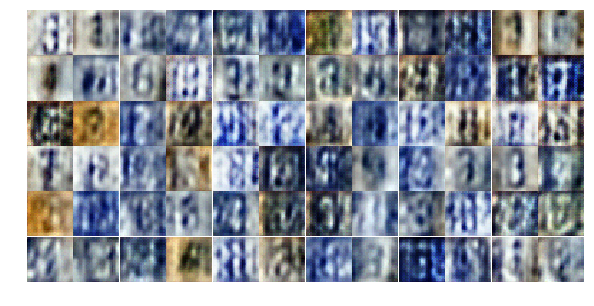

Epoch 2/25... Discriminator Loss: 1.1678... Generator Loss: 0.6378
Epoch 2/25... Discriminator Loss: 1.1687... Generator Loss: 0.5633
Epoch 2/25... Discriminator Loss: 1.0951... Generator Loss: 1.4052
Epoch 2/25... Discriminator Loss: 1.2298... Generator Loss: 0.6566
Epoch 2/25... Discriminator Loss: 0.9892... Generator Loss: 1.2416
Epoch 2/25... Discriminator Loss: 0.8169... Generator Loss: 1.0471
Epoch 2/25... Discriminator Loss: 1.1149... Generator Loss: 1.5598
Epoch 2/25... Discriminator Loss: 0.9104... Generator Loss: 1.2398
Epoch 2/25... Discriminator Loss: 1.7476... Generator Loss: 2.1925
Epoch 2/25... Discriminator Loss: 0.9709... Generator Loss: 1.9927


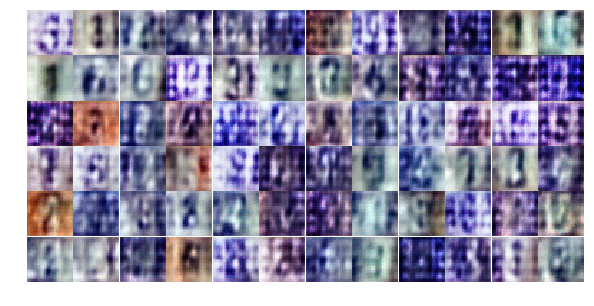

Epoch 2/25... Discriminator Loss: 0.9902... Generator Loss: 1.0650
Epoch 2/25... Discriminator Loss: 1.0657... Generator Loss: 0.7806
Epoch 2/25... Discriminator Loss: 0.6538... Generator Loss: 1.1799
Epoch 2/25... Discriminator Loss: 1.9206... Generator Loss: 0.2216
Epoch 2/25... Discriminator Loss: 1.0731... Generator Loss: 0.9855
Epoch 2/25... Discriminator Loss: 0.6094... Generator Loss: 1.3519
Epoch 2/25... Discriminator Loss: 1.2452... Generator Loss: 2.7419
Epoch 2/25... Discriminator Loss: 1.1032... Generator Loss: 0.9621
Epoch 2/25... Discriminator Loss: 0.9363... Generator Loss: 1.3618
Epoch 2/25... Discriminator Loss: 0.8017... Generator Loss: 1.2168


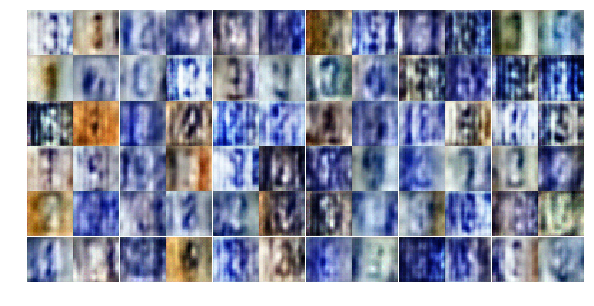

Epoch 2/25... Discriminator Loss: 0.9342... Generator Loss: 1.2198
Epoch 2/25... Discriminator Loss: 0.6854... Generator Loss: 1.6943
Epoch 2/25... Discriminator Loss: 0.8815... Generator Loss: 0.8556
Epoch 2/25... Discriminator Loss: 0.9930... Generator Loss: 0.9391
Epoch 3/25... Discriminator Loss: 0.6460... Generator Loss: 1.9326
Epoch 3/25... Discriminator Loss: 0.7710... Generator Loss: 0.9567
Epoch 3/25... Discriminator Loss: 0.8854... Generator Loss: 2.5746
Epoch 3/25... Discriminator Loss: 0.8637... Generator Loss: 0.7765
Epoch 3/25... Discriminator Loss: 0.6705... Generator Loss: 3.3040
Epoch 3/25... Discriminator Loss: 0.9712... Generator Loss: 0.8549


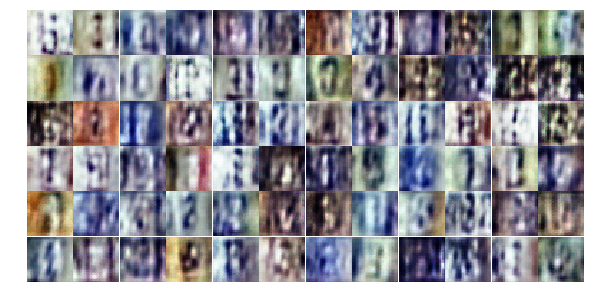

Epoch 3/25... Discriminator Loss: 0.3910... Generator Loss: 1.9017
Epoch 3/25... Discriminator Loss: 0.6616... Generator Loss: 1.7543
Epoch 3/25... Discriminator Loss: 0.9361... Generator Loss: 0.7293
Epoch 3/25... Discriminator Loss: 0.5686... Generator Loss: 2.3091
Epoch 3/25... Discriminator Loss: 0.6775... Generator Loss: 1.0138
Epoch 3/25... Discriminator Loss: 0.9676... Generator Loss: 0.6823
Epoch 3/25... Discriminator Loss: 0.5221... Generator Loss: 1.4707
Epoch 3/25... Discriminator Loss: 0.7157... Generator Loss: 1.0282
Epoch 3/25... Discriminator Loss: 1.5319... Generator Loss: 0.3057
Epoch 3/25... Discriminator Loss: 0.4324... Generator Loss: 1.7517


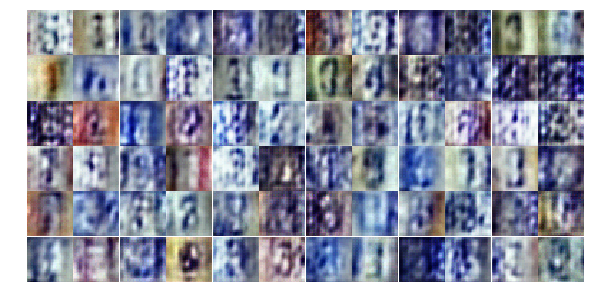

Epoch 3/25... Discriminator Loss: 0.6086... Generator Loss: 1.2871
Epoch 3/25... Discriminator Loss: 0.3318... Generator Loss: 2.0194
Epoch 3/25... Discriminator Loss: 0.7707... Generator Loss: 1.0092
Epoch 3/25... Discriminator Loss: 0.9064... Generator Loss: 1.3677
Epoch 3/25... Discriminator Loss: 1.3442... Generator Loss: 0.4269
Epoch 3/25... Discriminator Loss: 0.7878... Generator Loss: 2.0493
Epoch 3/25... Discriminator Loss: 1.9795... Generator Loss: 0.2158
Epoch 3/25... Discriminator Loss: 1.1843... Generator Loss: 0.5604
Epoch 3/25... Discriminator Loss: 0.5573... Generator Loss: 1.9258
Epoch 3/25... Discriminator Loss: 0.4931... Generator Loss: 1.9740


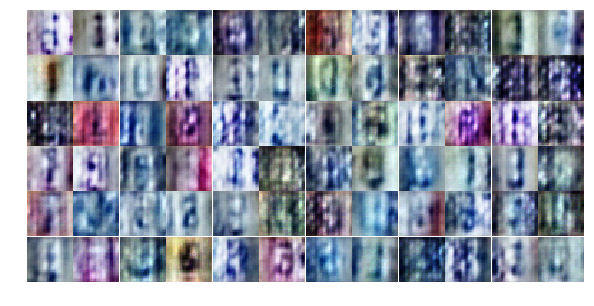

Epoch 3/25... Discriminator Loss: 1.0241... Generator Loss: 2.1364
Epoch 3/25... Discriminator Loss: 0.6208... Generator Loss: 1.8163
Epoch 3/25... Discriminator Loss: 0.9831... Generator Loss: 1.0547
Epoch 3/25... Discriminator Loss: 0.3025... Generator Loss: 1.9998
Epoch 3/25... Discriminator Loss: 0.3367... Generator Loss: 2.0318
Epoch 3/25... Discriminator Loss: 0.6924... Generator Loss: 0.9824
Epoch 3/25... Discriminator Loss: 1.4921... Generator Loss: 0.4382
Epoch 3/25... Discriminator Loss: 0.6297... Generator Loss: 1.7908
Epoch 3/25... Discriminator Loss: 0.8211... Generator Loss: 0.8801
Epoch 3/25... Discriminator Loss: 0.5799... Generator Loss: 1.4441


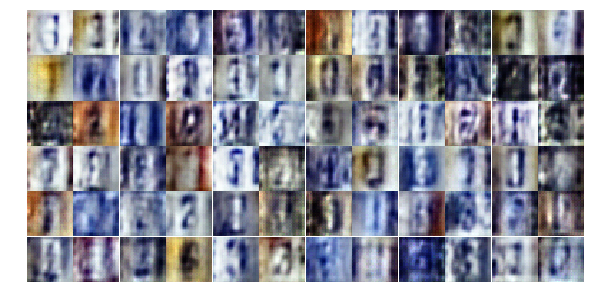

Epoch 3/25... Discriminator Loss: 0.7287... Generator Loss: 2.9353
Epoch 3/25... Discriminator Loss: 0.4300... Generator Loss: 1.6747
Epoch 3/25... Discriminator Loss: 0.4570... Generator Loss: 1.6725
Epoch 3/25... Discriminator Loss: 0.8626... Generator Loss: 0.8077
Epoch 3/25... Discriminator Loss: 0.5608... Generator Loss: 1.9638
Epoch 3/25... Discriminator Loss: 0.7018... Generator Loss: 0.9999
Epoch 3/25... Discriminator Loss: 0.4332... Generator Loss: 2.7041
Epoch 3/25... Discriminator Loss: 1.0511... Generator Loss: 0.7311
Epoch 3/25... Discriminator Loss: 0.5254... Generator Loss: 1.8585
Epoch 3/25... Discriminator Loss: 0.6580... Generator Loss: 1.1538


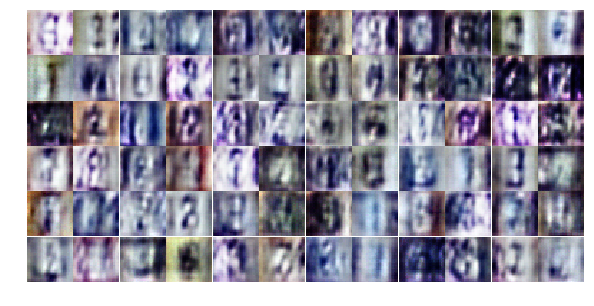

Epoch 3/25... Discriminator Loss: 0.8897... Generator Loss: 1.1250
Epoch 3/25... Discriminator Loss: 0.7338... Generator Loss: 1.0488
Epoch 3/25... Discriminator Loss: 0.6878... Generator Loss: 1.3427
Epoch 3/25... Discriminator Loss: 0.6323... Generator Loss: 1.3893
Epoch 3/25... Discriminator Loss: 0.9349... Generator Loss: 0.7168
Epoch 3/25... Discriminator Loss: 0.4616... Generator Loss: 1.6324
Epoch 3/25... Discriminator Loss: 0.7001... Generator Loss: 1.4019
Epoch 3/25... Discriminator Loss: 0.3884... Generator Loss: 2.4981
Epoch 3/25... Discriminator Loss: 0.7529... Generator Loss: 1.1233
Epoch 3/25... Discriminator Loss: 1.3877... Generator Loss: 0.4949


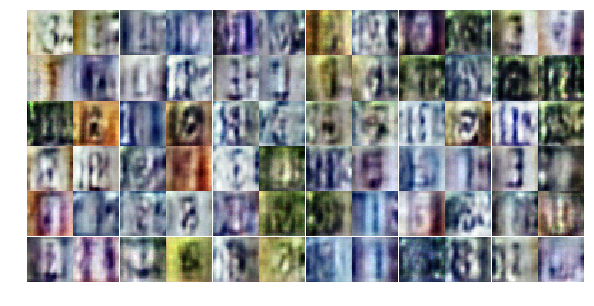

Epoch 3/25... Discriminator Loss: 0.5983... Generator Loss: 1.9030
Epoch 4/25... Discriminator Loss: 0.6931... Generator Loss: 1.0926
Epoch 4/25... Discriminator Loss: 1.1008... Generator Loss: 0.6271
Epoch 4/25... Discriminator Loss: 0.7775... Generator Loss: 0.9687
Epoch 4/25... Discriminator Loss: 0.5865... Generator Loss: 1.6119
Epoch 4/25... Discriminator Loss: 0.6269... Generator Loss: 1.1584
Epoch 4/25... Discriminator Loss: 0.7280... Generator Loss: 2.5062
Epoch 4/25... Discriminator Loss: 1.5051... Generator Loss: 2.1110
Epoch 4/25... Discriminator Loss: 0.4759... Generator Loss: 1.5368
Epoch 4/25... Discriminator Loss: 0.5439... Generator Loss: 1.2624


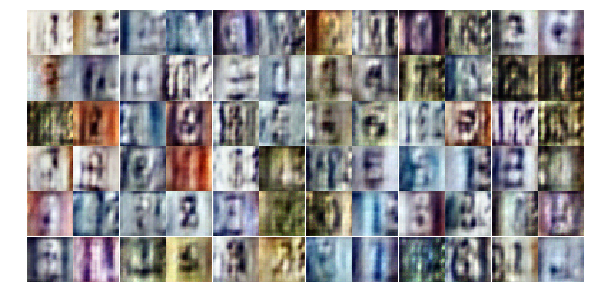

Epoch 4/25... Discriminator Loss: 0.6397... Generator Loss: 1.9954
Epoch 4/25... Discriminator Loss: 1.3232... Generator Loss: 0.4069
Epoch 4/25... Discriminator Loss: 1.0525... Generator Loss: 0.8631
Epoch 4/25... Discriminator Loss: 1.5449... Generator Loss: 0.4403
Epoch 4/25... Discriminator Loss: 1.0433... Generator Loss: 1.2886
Epoch 4/25... Discriminator Loss: 1.0542... Generator Loss: 0.9267
Epoch 4/25... Discriminator Loss: 0.4465... Generator Loss: 1.7697
Epoch 4/25... Discriminator Loss: 1.1469... Generator Loss: 0.5304
Epoch 4/25... Discriminator Loss: 0.4169... Generator Loss: 2.0712
Epoch 4/25... Discriminator Loss: 1.0239... Generator Loss: 1.8385


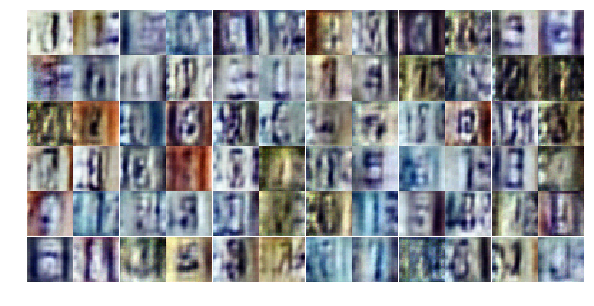

Epoch 4/25... Discriminator Loss: 0.6904... Generator Loss: 1.1587
Epoch 4/25... Discriminator Loss: 0.5635... Generator Loss: 2.2229
Epoch 4/25... Discriminator Loss: 1.0052... Generator Loss: 0.6575
Epoch 4/25... Discriminator Loss: 0.5623... Generator Loss: 1.7630
Epoch 4/25... Discriminator Loss: 0.7911... Generator Loss: 1.1015
Epoch 4/25... Discriminator Loss: 0.8739... Generator Loss: 2.5463
Epoch 4/25... Discriminator Loss: 1.5119... Generator Loss: 0.3859
Epoch 4/25... Discriminator Loss: 0.6170... Generator Loss: 1.3131
Epoch 4/25... Discriminator Loss: 0.3867... Generator Loss: 2.6286
Epoch 4/25... Discriminator Loss: 0.9452... Generator Loss: 0.6449


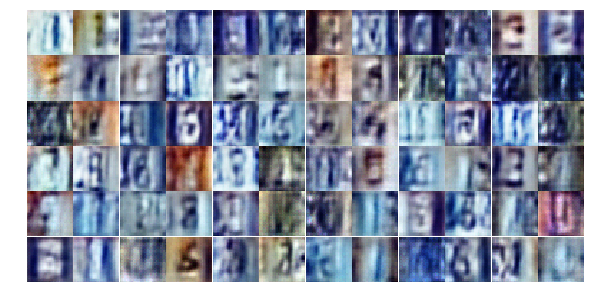

Epoch 4/25... Discriminator Loss: 0.9122... Generator Loss: 0.8337
Epoch 4/25... Discriminator Loss: 0.1909... Generator Loss: 3.9503
Epoch 4/25... Discriminator Loss: 0.5921... Generator Loss: 1.1974
Epoch 4/25... Discriminator Loss: 0.4869... Generator Loss: 1.7869
Epoch 4/25... Discriminator Loss: 0.3462... Generator Loss: 2.1172
Epoch 4/25... Discriminator Loss: 0.8755... Generator Loss: 0.7312
Epoch 4/25... Discriminator Loss: 0.4184... Generator Loss: 1.7980
Epoch 4/25... Discriminator Loss: 0.9706... Generator Loss: 0.6205
Epoch 4/25... Discriminator Loss: 0.5167... Generator Loss: 1.3172
Epoch 4/25... Discriminator Loss: 0.9942... Generator Loss: 0.6190


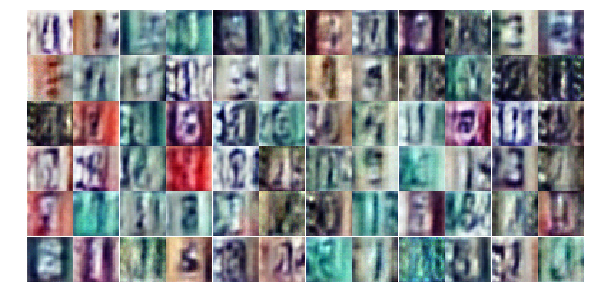

Epoch 4/25... Discriminator Loss: 0.3827... Generator Loss: 2.3498
Epoch 4/25... Discriminator Loss: 0.4054... Generator Loss: 2.3863
Epoch 4/25... Discriminator Loss: 0.3933... Generator Loss: 1.6309
Epoch 4/25... Discriminator Loss: 1.3157... Generator Loss: 2.0446
Epoch 4/25... Discriminator Loss: 0.2497... Generator Loss: 2.7385
Epoch 4/25... Discriminator Loss: 1.2496... Generator Loss: 0.5435
Epoch 4/25... Discriminator Loss: 1.0245... Generator Loss: 0.6786
Epoch 4/25... Discriminator Loss: 0.5992... Generator Loss: 1.0916
Epoch 4/25... Discriminator Loss: 0.3791... Generator Loss: 1.7642
Epoch 4/25... Discriminator Loss: 0.4809... Generator Loss: 1.4102


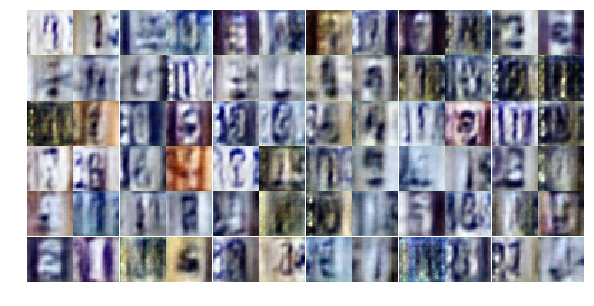

Epoch 4/25... Discriminator Loss: 0.3384... Generator Loss: 1.8712
Epoch 4/25... Discriminator Loss: 0.5179... Generator Loss: 2.1349
Epoch 4/25... Discriminator Loss: 0.1146... Generator Loss: 3.4312
Epoch 4/25... Discriminator Loss: 0.6433... Generator Loss: 1.5523
Epoch 4/25... Discriminator Loss: 0.3522... Generator Loss: 2.3171
Epoch 4/25... Discriminator Loss: 0.9631... Generator Loss: 0.6626
Epoch 4/25... Discriminator Loss: 0.9259... Generator Loss: 0.6170
Epoch 4/25... Discriminator Loss: 0.5901... Generator Loss: 2.9514
Epoch 4/25... Discriminator Loss: 0.5314... Generator Loss: 1.6459
Epoch 5/25... Discriminator Loss: 0.6430... Generator Loss: 1.3274


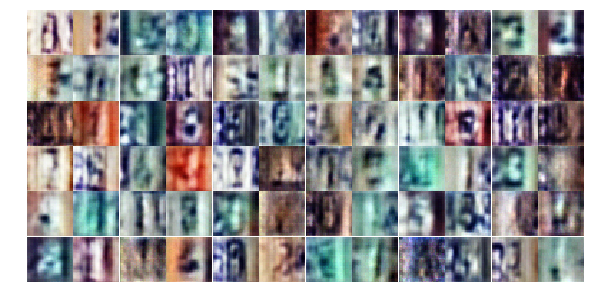

Epoch 5/25... Discriminator Loss: 0.3423... Generator Loss: 1.7837
Epoch 5/25... Discriminator Loss: 0.2597... Generator Loss: 3.0745
Epoch 5/25... Discriminator Loss: 0.3062... Generator Loss: 1.8454
Epoch 5/25... Discriminator Loss: 0.3882... Generator Loss: 1.6343
Epoch 5/25... Discriminator Loss: 0.2849... Generator Loss: 2.3242
Epoch 5/25... Discriminator Loss: 1.0314... Generator Loss: 1.6623
Epoch 5/25... Discriminator Loss: 0.3206... Generator Loss: 1.9672
Epoch 5/25... Discriminator Loss: 0.3325... Generator Loss: 1.7529
Epoch 5/25... Discriminator Loss: 0.6118... Generator Loss: 1.6855
Epoch 5/25... Discriminator Loss: 0.7061... Generator Loss: 2.0780


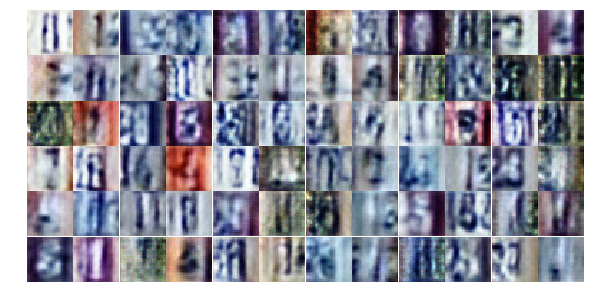

Epoch 5/25... Discriminator Loss: 0.6415... Generator Loss: 1.1009
Epoch 5/25... Discriminator Loss: 0.3997... Generator Loss: 1.9158
Epoch 5/25... Discriminator Loss: 0.3678... Generator Loss: 1.5919
Epoch 5/25... Discriminator Loss: 1.1757... Generator Loss: 0.5276
Epoch 5/25... Discriminator Loss: 0.6537... Generator Loss: 1.9057
Epoch 5/25... Discriminator Loss: 0.4626... Generator Loss: 1.4505
Epoch 5/25... Discriminator Loss: 0.2660... Generator Loss: 2.3238
Epoch 5/25... Discriminator Loss: 0.8705... Generator Loss: 0.7664
Epoch 5/25... Discriminator Loss: 0.4889... Generator Loss: 1.6162
Epoch 5/25... Discriminator Loss: 0.3701... Generator Loss: 1.8294


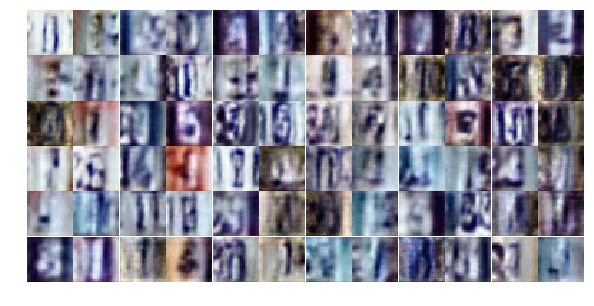

Epoch 5/25... Discriminator Loss: 0.7016... Generator Loss: 1.0236
Epoch 5/25... Discriminator Loss: 0.2717... Generator Loss: 2.3871
Epoch 5/25... Discriminator Loss: 0.7521... Generator Loss: 3.4979
Epoch 5/25... Discriminator Loss: 1.0363... Generator Loss: 0.6514
Epoch 5/25... Discriminator Loss: 0.9885... Generator Loss: 0.6006
Epoch 5/25... Discriminator Loss: 1.0048... Generator Loss: 0.6760
Epoch 5/25... Discriminator Loss: 0.4483... Generator Loss: 1.9481
Epoch 5/25... Discriminator Loss: 0.3777... Generator Loss: 1.9637
Epoch 5/25... Discriminator Loss: 0.4009... Generator Loss: 1.6071
Epoch 5/25... Discriminator Loss: 0.6126... Generator Loss: 0.9918


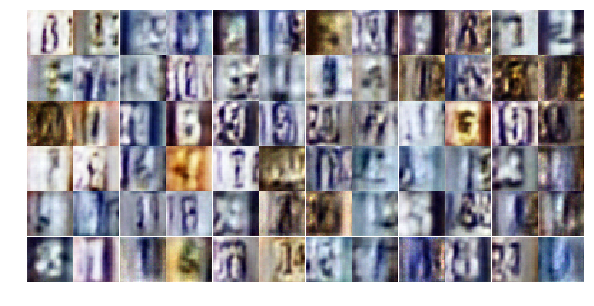

Epoch 5/25... Discriminator Loss: 1.5342... Generator Loss: 3.0249
Epoch 5/25... Discriminator Loss: 0.2431... Generator Loss: 3.1134
Epoch 5/25... Discriminator Loss: 0.5223... Generator Loss: 2.3684
Epoch 5/25... Discriminator Loss: 0.2975... Generator Loss: 1.9491
Epoch 5/25... Discriminator Loss: 0.5257... Generator Loss: 3.0988


In [ ]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

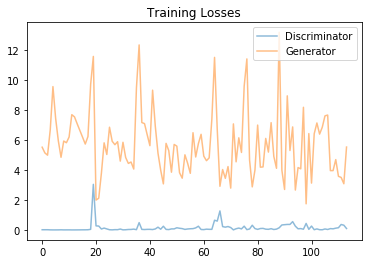

In [47]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

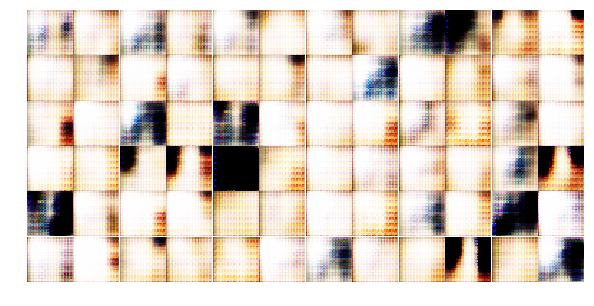

In [48]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))